In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import spacy
from gensim.models import KeyedVectors  
from sklearn.metrics.pairwise import cosine_similarity  

nltk.download('stopwords')
nltk.download('punkt')

nlp = spacy.load("en_core_web_sm")
nltk_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def remove_special_chars_and_punctuation(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

def remove_single_alphabet_tokens(text):
    return re.sub(r'\b[a-zA-Z]\b', '', text)

def remove_numerical_tokens(text):
    return re.sub(r'\b\d+\b', '', text)

def remove_alphanumeric_tokens(text):
    return re.sub(r'\b(?=.*\d)(?=.*[a-zA-Z])[a-zA-Z0-9]+\b', '', text)

def remove_pgp_key_patterns(text):
    return re.sub(r'\b(pgp|begin|end|key|public|block)\b', '', text, flags=re.IGNORECASE)

def remove_tokens_with_non_standard_characters(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)

def custom_preprocessor(text):
    text = remove_special_chars_and_punctuation(text)
    text = remove_single_alphabet_tokens(text)
    text = remove_numerical_tokens(text)
    text = remove_alphanumeric_tokens(text)
    text = remove_pgp_key_patterns(text)
    text = remove_tokens_with_non_standard_characters(text)
    words = text.lower().split()
    words = [word for word in words if word not in nltk_stopwords]
    return ' '.join(words)

def extract_nouns_pronouns_and_ner(text, ner_labels=None):
    doc = nlp(text)
    
    if ner_labels is None:
        ner_labels = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT'] 
    
    extracted_terms = set()
    
    for token in doc:
        if token.pos_ in ['NOUN', 'PROPN'] and token.text.lower() not in nltk_stopwords:
            extracted_terms.add(token.text)
        elif token.ent_type_ in ner_labels:
            extracted_terms.add(token.text)

    processed_terms = [custom_preprocessor(term) for term in extracted_terms]
    
    return ' '.join([term for term in processed_terms if term.strip()])

In [3]:
# Function to calculate topic diversity for NMF models
def calculate_topic_diversity(nmf_model, vectorizer, num_top_words=30):
    topics = []
    for topic in nmf_model.components_:
        top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-num_top_words-1:-1]]
        topics.append(top_words)

    # Flatten the list of top words across all topics
    all_top_words = [word for topic in topics for word in topic]

    # Calculate the unique words
    unique_words = set(all_top_words)

    # Topic diversity is the ratio of unique words to the total number of top words
    total_words = len(all_top_words)
    topic_diversity_score = len(unique_words) / total_words if total_words > 0 else 0

    return topic_diversity_score

# Function to save top words for NMF topics
def save_top_words_nmf(nmf_model, vectorizer, year, num_words=30, filename='nmf_topics_all_years.txt'):
    with open(filename, 'a') as f:
        f.write(f"\nTopics for year {year}:\n")
        for idx, topic in enumerate(nmf_model.components_):
            top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-num_words-1:-1]]
            f.write(f"Topic {idx + 1}: {' '.join(top_words)}\n")
    print(f"Top {num_words} words for each topic saved for year {year} into {filename}.")


In [4]:
input_file_path = 'cleaned_english_posts.csv'
data = pd.read_csv(input_file_path)

# Applying processing
data['processed_content'] = data['post_content'].fillna('').apply(lambda x: extract_nouns_pronouns_and_ner(str(x)))

# Removing empty rows
data = data[data['processed_content'].str.strip() != '']

# Getting the unique years
years = data['year'].unique()

In [5]:
fasttext_model_path = 'final_fasttext_model.bin'

# Load the FastText model
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=True)

print(f"FastText model loaded from {fasttext_model_path}")

FastText model loaded from final_fasttext_model.bin


In [6]:
# Initializing variables to store results and NMF models
nmf_models = {}
tfidf_feature_names_by_year = {}
topic_diversity_scores = []
years_list = []
iwec_scores_per_year = {}  # To store IWEC scores per year

total_docs = 0
weighted_diversity = 0
overall_weighted_iwec = 0  # To accumulate overall weighted IWEC score


In [7]:
years = data['year'].unique()

for year in years:
    # Filter the DataFrame for the specific year
    df_year = data[data['year'] == year]

    # Vectorizing the processed content using TF-IDF with default parameters
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df_year['processed_content'])
    tfidf_feature_names = vectorizer.get_feature_names_out()

    # Applying NMF to the TF-IDF matrix with default parameters
    num_topics = 10  # Adjust the number of topics as needed
    nmf_model = NMF(n_components=num_topics,  max_iter=500, random_state=42)
    nmf_topics = nmf_model.fit_transform(tfidf_matrix)

    # Calculating topic diversity for the NMF model
    topic_diversity_score = calculate_topic_diversity(nmf_model, vectorizer)

    # Saving the model and its feature names
    nmf_models[year] = nmf_model
    tfidf_feature_names_by_year[year] = tfidf_feature_names

    # Displaying the topics for the year with top 30 words
    save_top_words_nmf(nmf_model, vectorizer, year)

    # Creating and saving word clouds for each topic
    for topic_idx, topic in enumerate(nmf_model.components_):
        num_words_for_wordcloud = 100
        # Get the top words and their frequencies
        top_indices = topic.argsort()[:-num_words_for_wordcloud-1:-1]
        word_freq = {}
        for i in top_indices:
            word = tfidf_feature_names[i]
            freq = topic[i]
            if np.isfinite(freq) and freq > 0:
                word_freq[word] = freq
        # Checking if word_freq is not empty
        if not word_freq:
            print(f"No valid words for word cloud in Year {year}, Topic {topic_idx + 1}")
            continue
        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        # Save wordclouds
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Year {year}, Topic {topic_idx + 1}")
        plt.savefig(f"nmf_wordcloud_year_{year}_topic_{topic_idx + 1}.png")
        plt.close()

    # Storing topic diversity scores for weighted averages
    num_docs = len(df_year)
    total_docs += num_docs
    weighted_diversity += topic_diversity_score * num_docs
    topic_diversity_scores.append(topic_diversity_score)
    years_list.append(year)

    ### IWEC Calculation Starts Here ###
    # Number of top words to consider
    n_top_words = 10  

    # Extracting the top N words for each topic
    topic_words = []
    for topic in nmf_model.components_:
        top_words = [tfidf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_words.append(top_words)

    # Computing IWEC for these topics
    iwec_scores = []
    for words in topic_words:
        # Retrieving embeddings for the words
        embeddings = [fasttext_model[word] for word in words if word in fasttext_model]
        # Checking if embeddings are available
        if len(embeddings) < 2:
            coherence = 0.0
        else:
            similarities = cosine_similarity(embeddings)
            idx_upper = np.triu_indices_from(similarities, k=1)
            coherence = np.mean(similarities[idx_upper])
        iwec_scores.append(coherence)

    # Summing over documents to get topic weights
    topic_weights = np.sum(nmf_topics, axis=0)

    # Normalizing to get topic proportions
    topic_proportions = topic_weights / np.sum(topic_weights)

    # Computing weighted average IWEC score for the year
    weighted_iwec_score = np.sum(np.array(iwec_scores) * topic_proportions)

    # Storing the weighted IWEC score
    iwec_scores_per_year[year] = weighted_iwec_score

    # Accumulating overall weighted IWEC score
    overall_weighted_iwec += weighted_iwec_score * num_docs

    print(f"Year {year}: Topic Diversity Score = {topic_diversity_score:.4f}, Weighted IWEC Score = {weighted_iwec_score:.4f}")

Top 30 words for each topic saved for year 2024 into nmf_topics_all_years.txt.
Year 2024: Topic Diversity Score = 0.9067, Weighted IWEC Score = 0.4401
Top 30 words for each topic saved for year 2021 into nmf_topics_all_years.txt.
Year 2021: Topic Diversity Score = 0.8333, Weighted IWEC Score = 0.4648
Top 30 words for each topic saved for year 2023 into nmf_topics_all_years.txt.
Year 2023: Topic Diversity Score = 0.7700, Weighted IWEC Score = 0.4001
Top 30 words for each topic saved for year 2022 into nmf_topics_all_years.txt.
Year 2022: Topic Diversity Score = 0.7500, Weighted IWEC Score = 0.3943
Top 30 words for each topic saved for year 2020 into nmf_topics_all_years.txt.
Year 2020: Topic Diversity Score = 0.8400, Weighted IWEC Score = 0.4225
Top 30 words for each topic saved for year 2019 into nmf_topics_all_years.txt.
Year 2019: Topic Diversity Score = 0.8233, Weighted IWEC Score = 0.4258
Top 30 words for each topic saved for year 2018 into nmf_topics_all_years.txt.
Year 2018: Topi

In [8]:
# Calculating final weighted topic diversity and IWEC scores
avg_weighted_diversity = weighted_diversity / total_docs
avg_weighted_iwec = overall_weighted_iwec / total_docs
print(f"Weighted Average Topic Diversity Score Across Years: {avg_weighted_diversity:.4f}")
print(f"Overall Weighted Average IWEC Score Across Years: {avg_weighted_iwec:.4f}")

Weighted Average Topic Diversity Score Across Years: 0.8426
Overall Weighted Average IWEC Score Across Years: 0.4245


In [9]:
# Sorting years and corresponding topic diversity scores by year
sorted_years_data = sorted(zip(years_list, topic_diversity_scores), key=lambda x: x[0])
sorted_years_list, sorted_topic_diversity_scores = zip(*sorted_years_data)

# Sorting IWEC scores
sorted_years_iwec = sorted(iwec_scores_per_year.keys())
sorted_iwec_scores = [iwec_scores_per_year[year] for year in sorted_years_iwec]

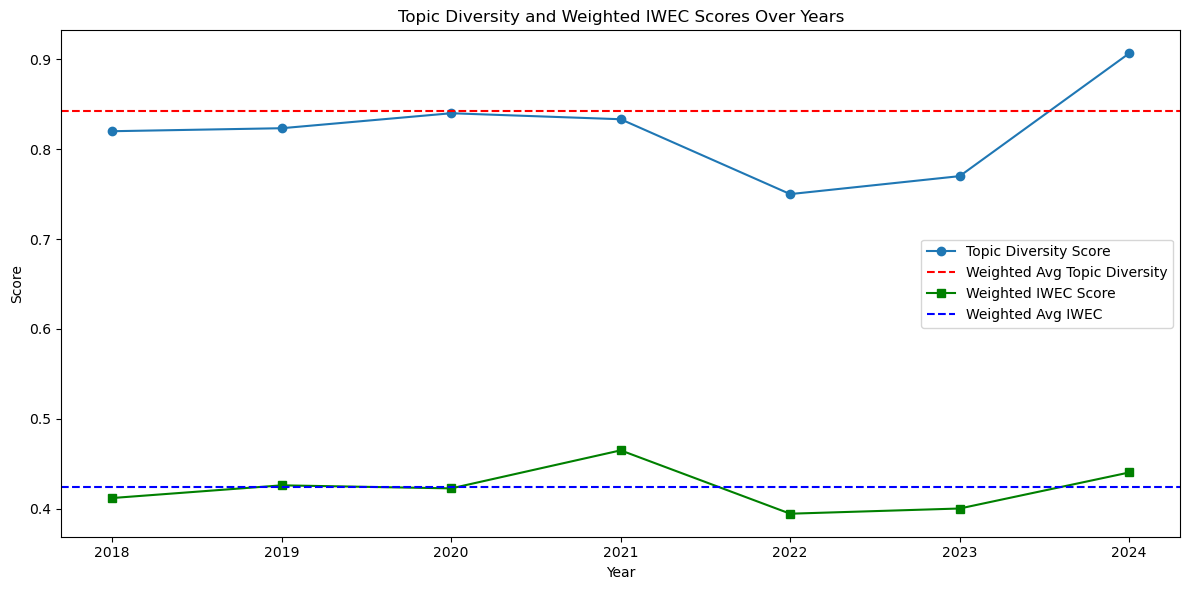

In [10]:
# Plotting the results with sorted data
plt.figure(figsize=(12, 6))

# Plot Topic Diversity Scores
plt.plot(sorted_years_list, sorted_topic_diversity_scores, marker='o', label='Topic Diversity Score')
plt.axhline(y=avg_weighted_diversity, color='red', linestyle='--', label='Weighted Avg Topic Diversity')

# Plot IWEC Scores on the same graph
plt.plot(sorted_years_iwec, sorted_iwec_scores, marker='s', color='green', label='Weighted IWEC Score')
plt.axhline(y=avg_weighted_iwec, color='b', linestyle='--', label='Weighted Avg IWEC')

plt.title('Topic Diversity and Weighted IWEC Scores Over Years')
plt.xlabel('Year')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()
